Datos de temperatura: (68493, 15)
Datos de calidad del aire: (137376, 9)


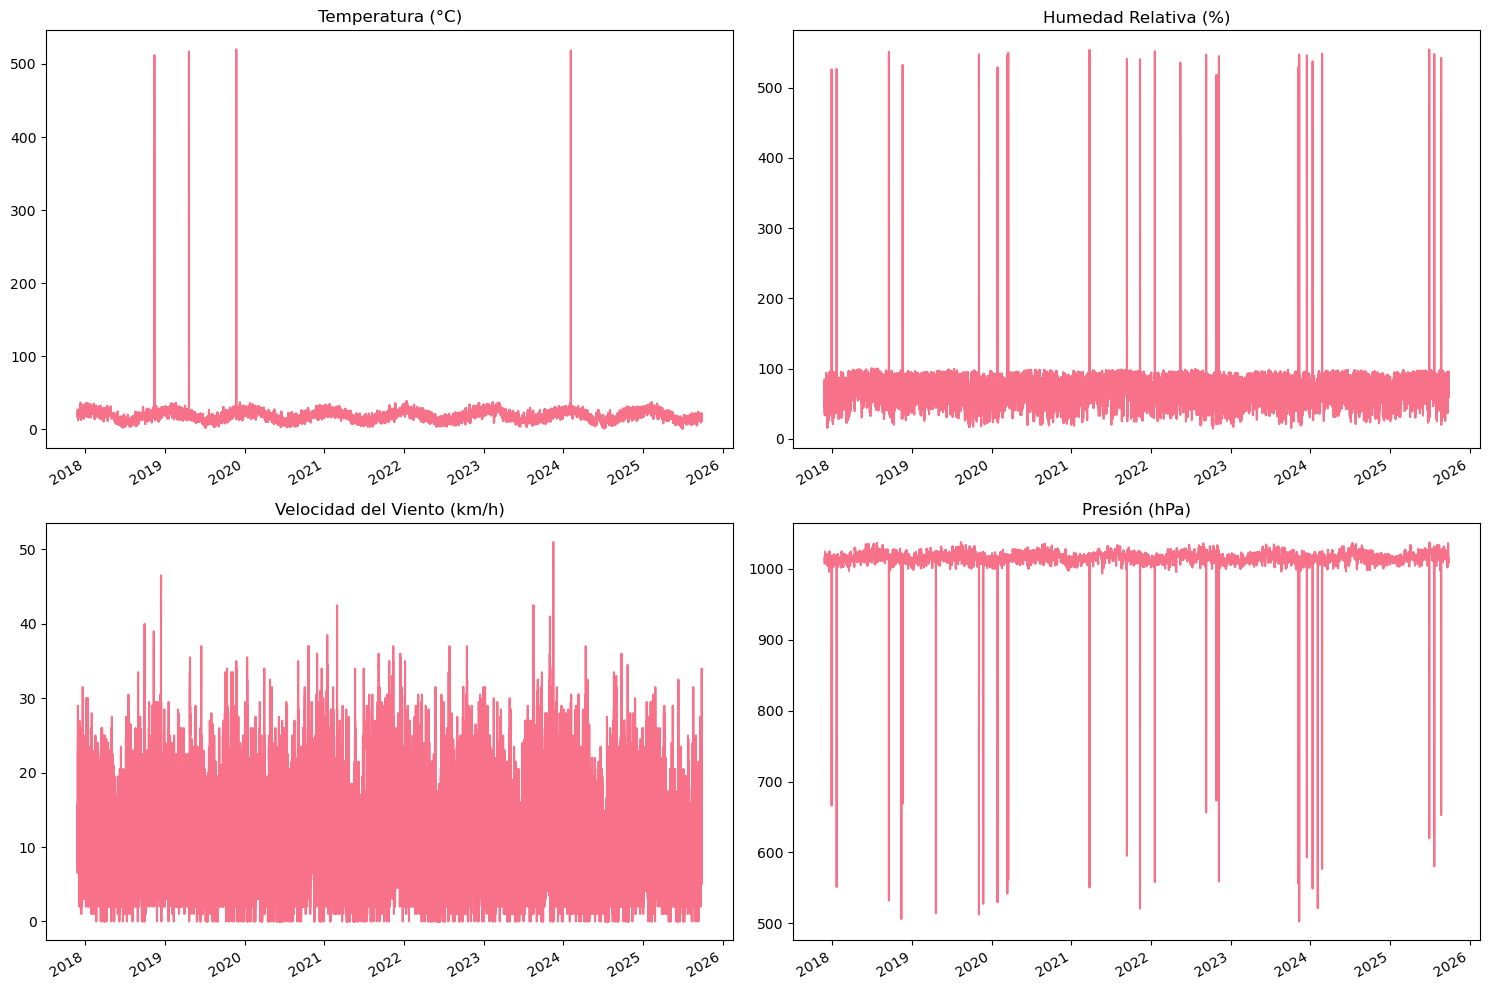

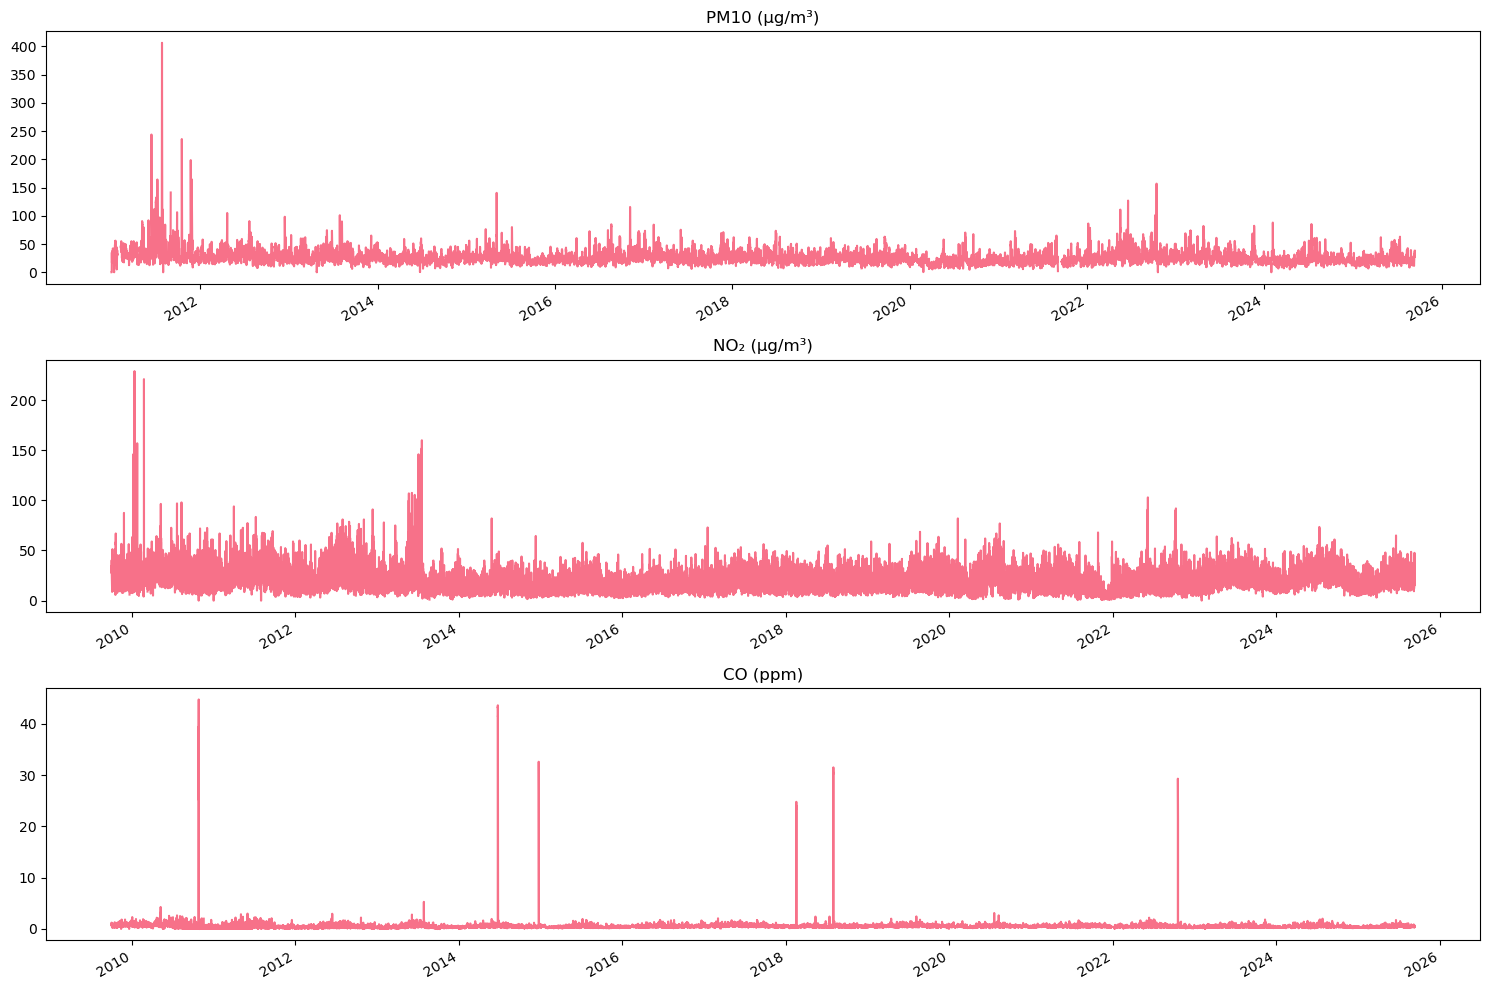

Análisis de estacionalidad - Temperatura


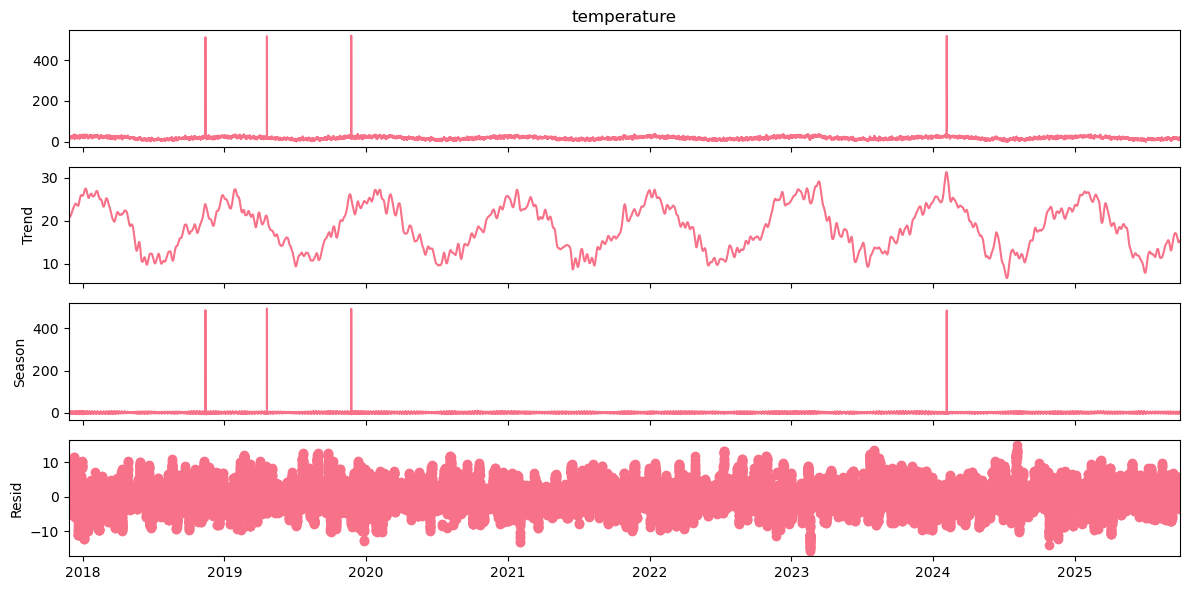

Análisis de estacionalidad - PM10


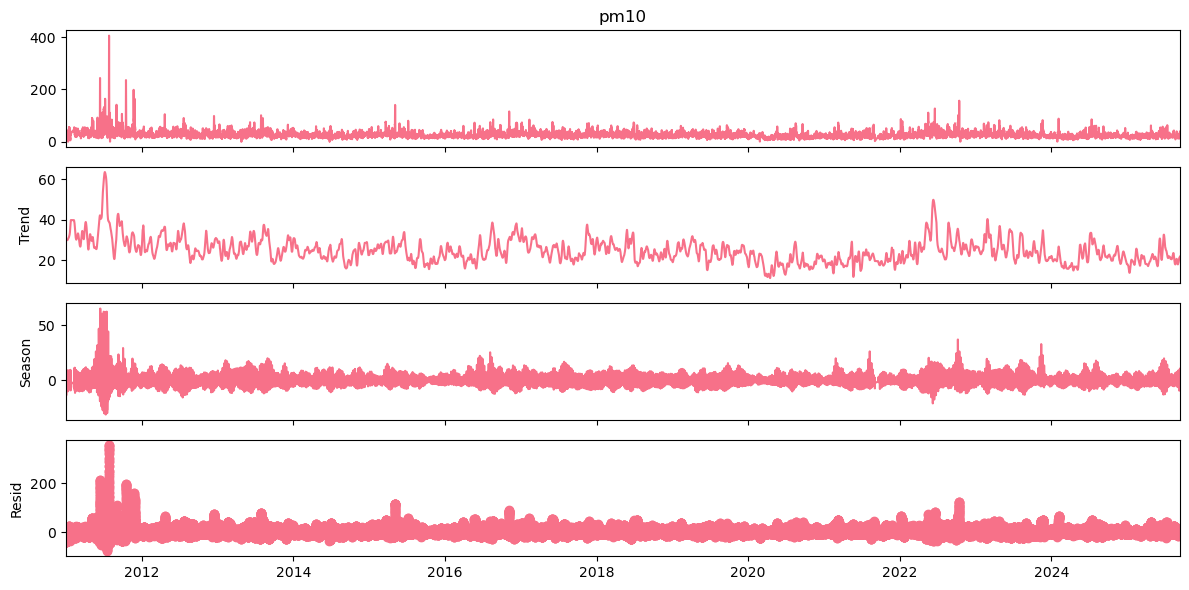

Análisis espectral - Temperatura


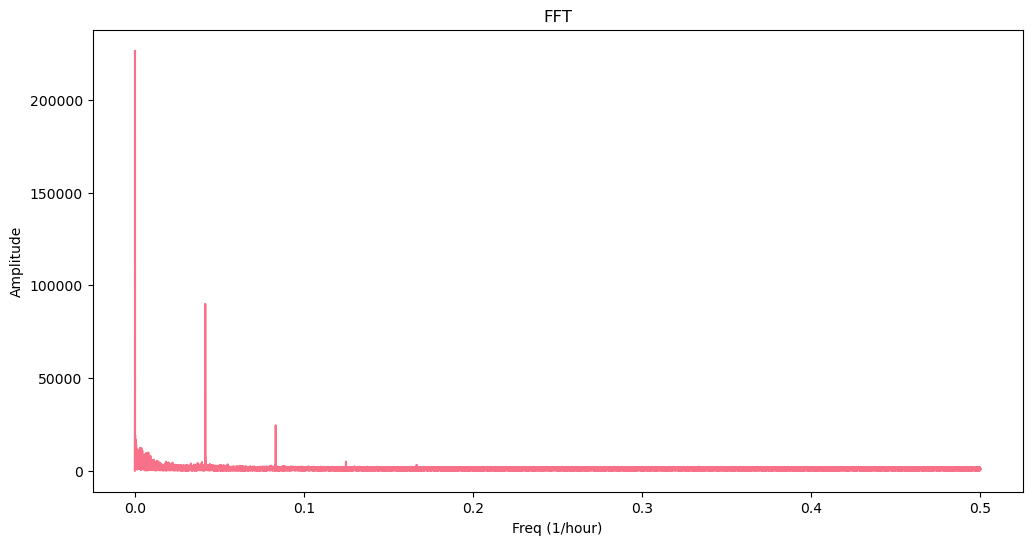

Análisis espectral - Calidad del Aire


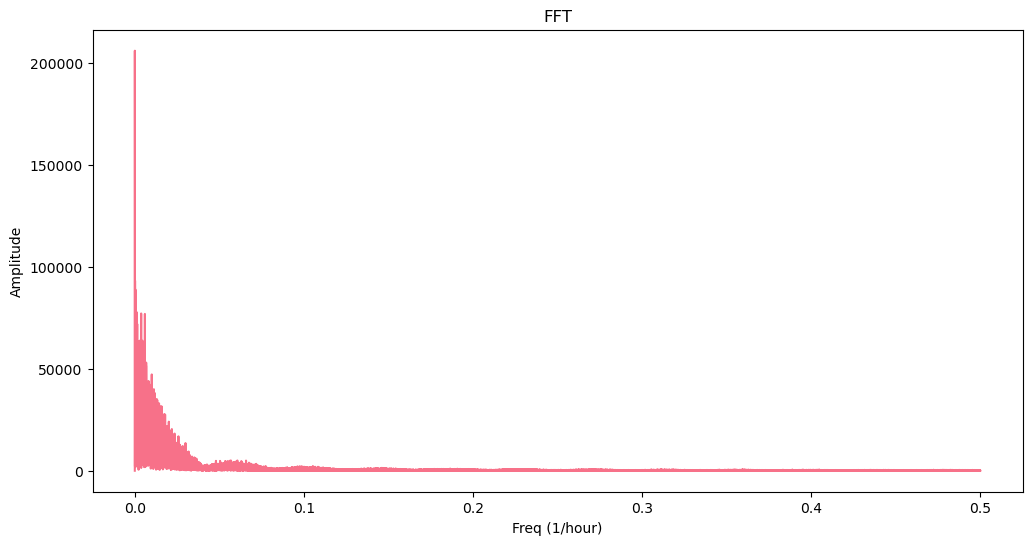

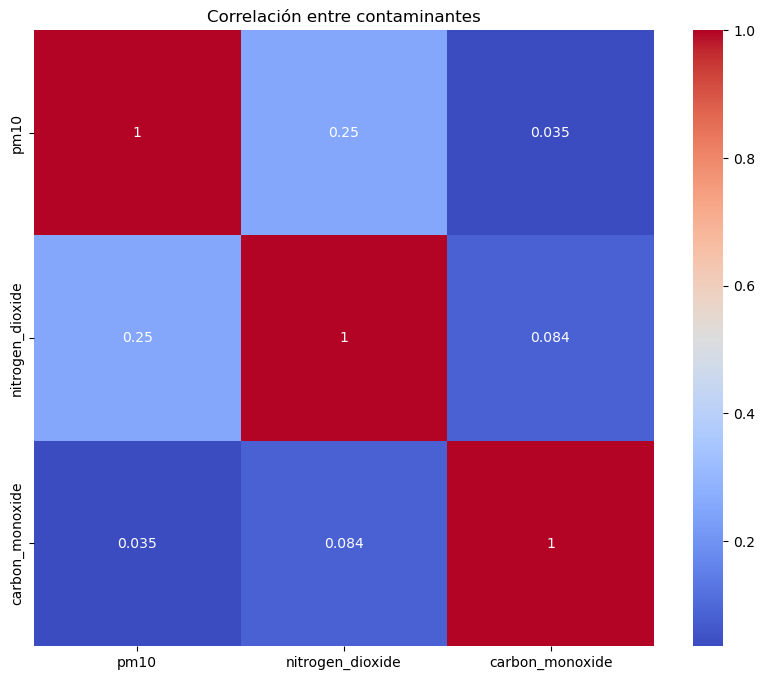

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import importlib.util

spec = importlib.util.spec_from_file_location("config", "../config/__init__.py")
config = importlib.util.module_from_spec(spec)
sys.modules["config"] = config
spec.loader.exec_module(config)

spec = importlib.util.spec_from_file_location("ts_weather_pipeline", "../ts_weather_pipeline/__init__.py")
ts_weather_pipeline = importlib.util.module_from_spec(spec)
sys.modules["ts_weather_pipeline"] = ts_weather_pipeline
spec.loader.exec_module(ts_weather_pipeline)

from ts_weather_pipeline.api import fetch_open_meteo_archive
from ts_weather_pipeline.preprocessing import fill_and_resample
from ts_weather_pipeline.analysis import adf_test, plot_decomposition, plot_fft, plot_pollutant_correlation

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# Descargar datos de temperatura
#print("Descargando datos de temperatura...")
#df_temp = fetch_open_meteo_archive(
#    lat=-34.6037, 
#    lon=-58.3816, 
#    start_date="2020-01-01",
#    end_date="2025-09-10",
#    hourly_vars=["temperature_2m", "relativehumidity_2m", "windspeed_10m", "precipitation"]
#)
#df_temp = fill_and_resample(df_temp, freq="H")

df_temp = pd.read_csv("../data/temperature-data.csv.gz", parse_dates=[0], index_col=0, compression='gzip')
print(f"Datos de temperatura: {df_temp.shape}")

# Descargar datos de calidad del aire
# print("Descargando datos de calidad del aire...")
#df_air = fetch_open_meteo_archive(
#    lat=-34.6037, 
#    lon=-58.3816, 
#    start_date="2020-01-01",
#    end_date="2025-09-10",
#    hourly_vars=["pm2_5", "pm10", "nitrogen_dioxide", "ozone"]
#)


#df_air = fill_and_resample(df_air, freq="H")
df_air = pd.read_csv("../data/air-quality-data.csv.gz", parse_dates=[0], index_col=0, compression='gzip')
print(f"Datos de calidad del aire: {df_air.shape}")

# Visualizar datos de temperatura
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
df_temp['temperature'].plot(ax=axes[0, 0], title='Temperatura (°C)')
df_temp['relativehumidity'].plot(ax=axes[0, 1], title='Humedad Relativa (%)')
df_temp['windspeed'].plot(ax=axes[1, 0], title='Velocidad del Viento (km/h)')
df_temp['pressure'].plot(ax=axes[1, 1], title='Presión (hPa)')
#df_temp['windangle'].plot(ax=axes[2, 0], title='Dirección del Viento (°)')
plt.tight_layout()
plt.show()

# Visualizar datos de calidad del aire
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
#if 'pm2_5' in df_air.columns:
#    df_air['pm2_5'].plot(ax=axes[0, 0], title='PM2.5 (μg/m³)')
if 'pm10' in df_air.columns:
    df_air['pm10'].plot(ax=axes[0], title='PM10 (μg/m³)')
if 'nitrogen_dioxide' in df_air.columns:
    df_air['nitrogen_dioxide'].plot(ax=axes[1], title='NO₂ (μg/m³)')
if 'carbon_monoxide' in df_air.columns:
    df_air['carbon_monoxide'].plot(ax=axes[2], title='CO (ppm)')
plt.tight_layout()
plt.show()

# Análisis de estacionalidad - Temperatura
print("Análisis de estacionalidad - Temperatura")
plot_decomposition(df_temp['temperature'].dropna(), period=24*7)  # Estacionalidad semanal

# Análisis de estacionalidad - PM2.5 (si disponible)
if 'pm10' in df_air.columns:
    print("Análisis de estacionalidad - PM10")
    plot_decomposition(df_air['pm10'].dropna(), period=24*7)

# Análisis espectral (FFT)
print("Análisis espectral - Temperatura")
plot_fft(df_temp['temperature'], fs=1.0)

print("Análisis espectral - Calidad del Aire")
plot_fft(df_air['pm10'], fs=1.0)

# Correlación entre contaminantes
if all(col in df_air.columns for col in ['pm10', 'nitrogen_dioxide', 'carbon_monoxide']):
    plot_pollutant_correlation(df_air, pollutants=['pm10', 'nitrogen_dioxide', 'carbon_monoxide'])



# Guardar datos 
# df_temp.to_csv('../data/temperature_data.csv')
# df_air.to_csv('../data/air_quality_data.csv')
# print("Datos guardados en data/temperature_data.csv y data/air_quality_data.csv")